In [1]:
import pandas as pd
import seaborn as sns

In [2]:
SC_expr = pd.read_csv("STUDY_CLUSTER_human_mouse_ineurons_logcpt_mean.tsv",sep="\t",index_col=0)
SC_p = pd.read_csv("STUDY_CLUSTER_human_mouse_ineurons_perc.tsv",sep="\t",index_col=0)

In [3]:
import pandas as pd
import scipy
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt

def mapping(data1, data2, alg='NNLS'):
    """
    Performs matrix decomposition using NNLS or Lasso regression.

    Args:
    - data1: DataFrame with features to map (matrix A).
    - data2: DataFrame with target clusters (each column is vector b).
    - alg: Algorithm to use for decomposition ('NNLS' or 'lasso').

    Returns:
    - x_total: DataFrame of mapped coefficients for each cluster.
    """
    # Initialize empty dataframe to store results
    x_total = pd.DataFrame(columns=data1.columns, index=data2.columns)
    
    A = data1  # Basis matrix

    for cluster in data2.columns:
        b = data2[cluster]  # Target vector for each cluster
        
        if alg == 'NNLS':
            # Non-Negative Least Squares (NNLS)
            x, _ = scipy.optimize.nnls(A, b, maxiter=250)
        elif alg == 'lasso':
            # Lasso regression with positive coefficients constraint
            model = Lasso(alpha=1, positive=True)
            model.fit(A, b)
            x = model.coef_
        else:
            raise ValueError("Please choose between 'NNLS' or 'lasso' for mapping")
        
        x_total.loc[cluster] = x  # Store the resulting coefficients
    
    return x_total.astype(float)


def match_atlas(atlas1, atlas2, marker_genes, alg='NNLS', visualize=True):
    """
    Matches clusters between two atlases using marker genes and chosen mapping algorithm.
    
    Args:
    - atlas1: DataFrame representing the first atlas.
    - atlas2: DataFrame representing the second atlas.
    - marker_genes: List of marker genes used for matching.
    - alg: Algorithm for mapping ('NNLS' or 'lasso').
    - visualize: Boolean to indicate whether to plot the heatmap of matches.

    Returns:
    - a: Coefficients from atlas1 to atlas2 mapping.
    - b: Coefficients from atlas2 to atlas1 mapping.
    - c: Product matrix of mappings.
    - d: DataFrame with matched cluster pairs.
    """
    # Find common genes between both atlases and the marker genes
    common_genes = list(set(atlas1.index) & set(atlas2.index) & set(marker_genes))
    print(f"Number of common genes: {len(common_genes)}")

    if len(common_genes) == 0:
        raise ValueError("No common genes found between the atlases and marker genes.")

    # Extract the subset of common genes for both atlases
    avg_genedf_use = atlas1.loc[common_genes]
    ls_atlas_use = atlas2.loc[common_genes].dropna(axis=1)  # Drop clusters with missing values

    # Perform the forward and reverse mapping
    a = mapping(avg_genedf_use, ls_atlas_use, alg=alg)  # atlas1 -> atlas2: pxq
    b = mapping(ls_atlas_use, avg_genedf_use, alg=alg)  # atlas2 -> atlas1: qxp

    # Calculate product of forward and reverse mappings
    c = a * b.T  # Multiplication to identify matching clusters

    # Z-score normalization of the product matrix
    c_Z = (c.T - c.T.mean()) / c.T.std()
    c_Z = c_Z.T.dropna()  # Drop any columns with NaNs

    # Identify clusters with significant matches (based on a threshold of 0.01)
    c_max = c.max()
    matched_clusters = list(c_max[c_max > 0.01].index)

    if not matched_clusters:
        raise ValueError("No significant matches found between the clusters.")

    matched_clusters_partners = list(c[matched_clusters].idxmax())

    # Optionally visualize the heatmap of matched clusters
    if visualize:
        sns.heatmap(c.loc[matched_clusters_partners, matched_clusters], vmax=0.1, cmap='viridis')
        plt.show()
        plt.close()

    # Create a dataframe showing matched clusters and their partners
    d = pd.DataFrame({'Cluster': matched_clusters, 'Matched_Partner': matched_clusters_partners})
    d.set_index('Cluster', inplace=True)

    return a, b, c, d


In [4]:
marker_genes = []
marker_genes_dict = {}
for sample in ['iGlut_post','iGlut_pre','iGABA_post','iGABA_pre']:
    marker_genes_df = pd.read_csv('~/jjans/analysis/iNeurons/'+sample+'_dr_clustered_raw_merged_markers.tsv',sep="\t",index_col=0)
    marker_genes_sample = list(set(marker_genes_df.groupby("cluster_old").head(n=5).index))
    marker_genes = marker_genes + marker_genes_sample
    marker_genes_dict[sample] = marker_genes_df

In [5]:
marker_genes = list(set(marker_genes))
ineuron_columns = [x for x in SC_expr.columns if 'post' in x or 'pre' in x]
prim_columns = [x for x in SC_expr.columns if x not in ineuron_columns]

Number of common genes: 458


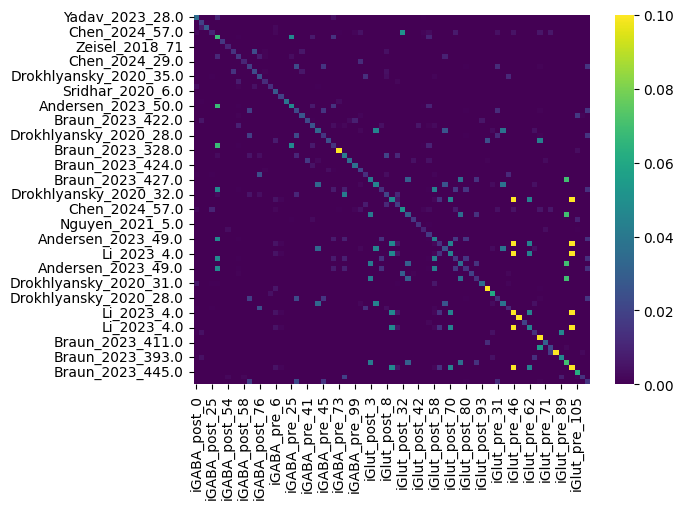

In [6]:
a,b,c,d = match_atlas(SC_expr[ineuron_columns],SC_expr[prim_columns],marker_genes=marker_genes,alg='NNLS')

In [7]:
import numpy as np
from scipy.optimize import nnls
import random
from multiprocessing import Pool, Manager

def run_nnls_for_subset(subset_genes, atlas1, atlas2, cluster1, cluster2, early_stop_threshold, stop_flag):
    """
    Helper function to run NNLS on a given subset of genes.
    Will stop early only if a subset gets a score lower than the early_stop_threshold.
    """
    if stop_flag.value:
        return float('inf'), subset_genes  # Return a high residual if stopping

    A_subset = atlas1.loc[subset_genes, cluster1].values.reshape(-1, 1)
    b_subset = atlas2.loc[subset_genes, cluster2].values
    x, residual = nnls(A_subset, b_subset)

    return residual, subset_genes

def optimize_nnls_parallel(atlas1, atlas2, marker_genes, cluster1, cluster2, subset_size=10, num_subsets=100, expr_threshold=1, num_processes=4, early_stop_threshold=0.05, random_seed=42):
    """
    Optimizes the NNLS score by selecting random subsets of marker genes and processing them in parallel.
    Stops early if a subset gets a score lower than early_stop_threshold.
    Can set a random seed for reproducibility.

    Args:
    - atlas1: DataFrame of gene expression (genes as rows, clusters as columns).
    - atlas2: DataFrame of gene expression (genes as rows, clusters as columns).
    - marker_genes: List of marker genes to sample from.
    - cluster1: The cluster from atlas1.
    - cluster2: The cluster from atlas2.
    - subset_size: Number of genes in each subset to randomly sample (default = 10).
    - num_subsets: Number of random subsets to try (default = 100).
    - expr_threshold: Minimum expression value to consider a gene as expressed (default = 1).
    - num_processes: Number of parallel processes to use (default = 4).
    - early_stop_threshold: Residual value below which the search will stop early (default = 0.05).
    - random_seed: Random seed for reproducibility (default = None).

    Returns:
    - best_subset: The subset of genes that optimized the NNLS score.
    - best_score: The NNLS score for the best subset.
    """
    
    # Set the random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Find common genes between both atlases and the marker genes
    common_genes = list(set(atlas1.index) & set(atlas2.index) & set(marker_genes))
    print(f"Number of common genes: {len(common_genes)}")

    if len(common_genes) == 0:
        raise ValueError("No common genes found between the atlases and marker genes.")

    # Filter based on expression threshold
    common_genes = [gene for gene in common_genes 
                    if atlas1.loc[gene, cluster1] > expr_threshold and 
                       atlas2.loc[gene, cluster2] > expr_threshold]

    if len(common_genes) < subset_size:
        raise ValueError("Too few genes passing the expression threshold.")

    # Generate random subsets
    subsets = [random.sample(common_genes, subset_size) for _ in range(num_subsets)]

    # Create a Manager object to handle the stop flag
    manager = Manager()
    stop_flag = manager.Value('i', False)

    # Prepare arguments for parallel execution
    args = [(subset, atlas1, atlas2, cluster1, cluster2, early_stop_threshold, stop_flag) for subset in subsets]

    best_score = float('inf')
    best_subset = None
    nbest_score = None
    # Use multiprocessing to parallelize NNLS calculation for each subset
    with Pool(processes=num_processes) as pool:
        for residual, subset in pool.starmap(run_nnls_for_subset, args):
            # Stop the loop if the stop_flag has been triggered, but only after updating best score
            if stop_flag.value:
                break
            
            # Track the subset with the lowest residual (best NNLS score)
            if residual < best_score:
                best_score = residual
                best_subset = subset

                # If the current residual is below the early_stop_threshold, set stop_flag to True
                if best_score < early_stop_threshold:
                    print(f"Found satisfactory subset with score: {best_score}")
                    stop_flag.value = True  # Trigger the stop for other processes

    if stop_flag.value:
        if best_score >= early_stop_threshold:
            print("Warning: Early stopping was triggered, but no subset met the threshold.")
        else:
            print("Early stopping successful. A subset met the threshold.")
    else:
        print("No Early stopping")

    return best_subset, best_score

import numpy as np
from scipy.optimize import nnls
import random

def optimize_nnls(atlas1, atlas2, marker_genes, cluster1, cluster2, subset_size=10, num_subsets=100,expr_threshold=None,random_seed=42,verbose=True):
    """
    Optimizes the NNLS score by selecting random subsets of marker genes.

    Args:
    - avg_genedf_use: DataFrame of gene expression (atlas1, genes as rows, clusters as columns).
    - ls_atlas_use: DataFrame of gene expression (atlas2, genes as rows, clusters as columns).
    - marker_genes: List of marker genes to sample from.
    - cluster1: The cluster from atlas1.
    - cluster2: The cluster from atlas2.
    - subset_size: Number of genes in each subset to randomly sample (default = 10).
    - num_subsets: Number of random subsets to try (default = 100).

    Returns:
    - best_subset: The subset of genes that optimized the NNLS score.
    - best_score: The NNLS score for the best subset.
    """
    # Set the random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    
    best_score = float('inf')  # We aim to minimize the NNLS residual
    best_subset = None

    # Find common genes between both atlases and the marker genes
    common_genes = list(set(atlas1.index) & set(atlas2.index) & set(marker_genes))
    if verbose:
        print(f"Number of common genes: {len(common_genes)}")

    if len(common_genes) == 0:
        raise ValueError("No common genes found between the atlases and marker genes.")

    if expr_threshold:
        common_genes = [gene for gene in common_genes 
                       if atlas1.loc[gene, cluster1] > expr_threshold and 
                          atlas2.loc[gene, cluster2] > expr_threshold]

    if len(common_genes) < subset_size:
        raise ValueError("Too few genes passing expressing threshold")

    # Extract gene expression data for the clusters from atlas1 and atlas2
#    atlas1_cluster1 = atlas1.loc[marker_genes, cluster1]
#    atlas2_cluster2 = atlas2.loc[marker_genes, cluster2]

    # Convert to numpy arrays for NNLS computation
#    avg_values = atlas1_cluster1.values
#    ls_values = atlas2_cluster2.values

    for _ in range(num_subsets):
        # Randomly sample a subset of genes
        subset_genes = random.sample(common_genes, subset_size)
        
        # Subset the gene expression data for the selected genes
        A_subset = atlas1.loc[subset_genes, cluster1].values.reshape(-1, 1)
        b_subset = atlas2.loc[subset_genes, cluster2].values

        # Run NNLS on the subset of genes
        x, residual = nnls(A_subset, b_subset)
        
        # Track the subset with the lowest residual (best NNLS score)
        if residual < best_score:
            best_score = residual
            best_subset = subset_genes

    return best_subset, best_score

array([[<Axes: title={'center': 'iGABA_post'}>,
        <Axes: title={'center': 'iGABA_pre'}>],
       [<Axes: title={'center': 'iGlut_post'}>,
        <Axes: title={'center': 'iGlut_pre'}>]], dtype=object)

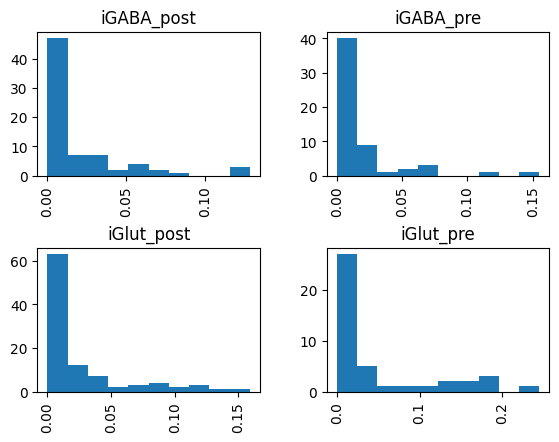

In [9]:
matched_clusters_scores = pd.read_csv("NNLS/NNLS_results_marker_genes.tsv",sep="\t",index_col=0)
matched_clusters_scores['regr_weight'].hist(by=matched_clusters_scores['sample'])

In [11]:
matched_clusters_scores.loc['iGABA_post_45']

primary_cluster    Braun_2023_384.0
regr_weight                     0.0
sample                   iGABA_post
Name: iGABA_post_45, dtype: object

In [10]:
min_clusters_filtered = ['iGABA_pre_55', 'iGABA_pre_60', 'iGABA_pre_76', 'iGABA_pre_99', 'iGlut_post_24', 'iGlut_post_28', 'iGlut_post_56', 'iGlut_post_58', 'iGlut_post_96', 'iGlut_pre_13', 'iGlut_pre_33', 'iGlut_pre_49', 'iGlut_pre_63', 'iGlut_pre_82', 'iGlut_pre_89', 'iGlut_pre_94']

In [12]:
TF_genes = pd.read_csv("/cluster/home/jjanssens/jjans/resources/geneLists/human_TFs/utoronto_human_tfs_v_1.01.txt",sep="\t",header=None)
TF_genes = list(set(TF_genes[0]))

In [13]:
synaptic_genes = pd.read_csv("/cluster/home/jjanssens/jjans/resources/geneLists/GO/synapse_assembly.txt",sep="\t",header=None)
synaptic_genes = list(set(synaptic_genes[1]))

In [14]:
oxphos_genes = pd.read_csv("/cluster/home/jjanssens/jjans/resources/geneLists/GO/oxphos.txt",sep="\t",header=None)
oxphos_genes = list(set(oxphos_genes[2]))

In [15]:
IC_genes = pd.read_csv("/cluster/home/jjanssens/jjans/resources/geneLists/HGNC/human_ion_channels.txt",sep="\t")
IC_genes = list(set(IC_genes['Approved symbol']))

In [16]:
NNLS_overview = []
for cluster in min_clusters_filtered:

    ineuron_cluster = cluster
    primary_cluster = matched_clusters_scores.loc[cluster,'primary_cluster']

    NNLS_genes = marker_genes
    NNLS_genes = [x for x in NNLS_genes if x in SC_expr.index]
    best_genes, best_score_marker = optimize_nnls(SC_expr, SC_expr, NNLS_genes, ineuron_cluster, primary_cluster, subset_size=len(NNLS_genes), num_subsets=1,verbose=False)
    corr_value = SC_expr.loc[NNLS_genes,[ineuron_cluster,primary_cluster]].corr(method='spearman')
    best_score_marker = corr_value.loc[ineuron_cluster,primary_cluster]

    
    NNLS_genes = TF_genes
    NNLS_genes = [x for x in NNLS_genes if x in SC_expr.index]
    print(len(NNLS_genes))
    best_genes, best_score_TF = optimize_nnls(SC_expr, SC_expr, NNLS_genes, ineuron_cluster, primary_cluster, subset_size=len(NNLS_genes), num_subsets=1,verbose=True)
    corr_value = SC_expr.loc[NNLS_genes,[ineuron_cluster,primary_cluster]].corr(method='spearman')
    best_score_TF = corr_value.loc[ineuron_cluster,primary_cluster]


    NNLS_genes = IC_genes
    NNLS_genes = [x for x in NNLS_genes if x in SC_expr.index]
    best_genes, best_score_IC = optimize_nnls(SC_expr, SC_expr, NNLS_genes, ineuron_cluster, primary_cluster, subset_size=len(NNLS_genes), num_subsets=1,verbose=False)
    corr_value = SC_expr.loc[NNLS_genes,[ineuron_cluster,primary_cluster]].corr(method='spearman')
    best_score_IC = corr_value.loc[ineuron_cluster,primary_cluster]


    NNLS_genes = synaptic_genes
    NNLS_genes = [x for x in NNLS_genes if x in SC_expr.index]
    best_genes, best_score_syn = optimize_nnls(SC_expr, SC_expr, NNLS_genes, ineuron_cluster, primary_cluster, subset_size=len(NNLS_genes), num_subsets=1,verbose=False)
    corr_value = SC_expr.loc[NNLS_genes,[ineuron_cluster,primary_cluster]].corr(method='spearman')
    best_score_syn = corr_value.loc[ineuron_cluster,primary_cluster]

    
    NNLS_genes = oxphos_genes
    NNLS_genes = [x for x in NNLS_genes if x in SC_expr.index]
    best_genes, best_score_ox = optimize_nnls(SC_expr, SC_expr, NNLS_genes, ineuron_cluster, primary_cluster, subset_size=len(NNLS_genes), num_subsets=1,verbose=False)
    corr_value = SC_expr.loc[NNLS_genes,[ineuron_cluster,primary_cluster]].corr(method='spearman')
    best_score_ox = corr_value.loc[ineuron_cluster,primary_cluster]

    
    NNLS_overview.append(dict(cluster=ineuron_cluster,
                             primary_cluster=primary_cluster,
                             marker=best_score_marker,
                             TF=best_score_TF,
                             IC=best_score_IC,
                             syn=best_score_syn,
                             ox=best_score_ox))
    
NNLS_overview = pd.DataFrame(NNLS_overview)

1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175
1175
Number of common genes: 1175


In [17]:
corr_value = SC_expr.loc[NNLS_genes,[ineuron_cluster,primary_cluster]].corr(method='spearman')

In [18]:
len(NNLS_genes)

79

In [19]:
NNLS_overview.index = NNLS_overview['cluster']

In [20]:
NNLS_overview

,cluster,primary_cluster,marker,TF,IC,syn,ox
cluster,,,,,,,
iGABA_pre_55,iGABA_pre_55,Braun_2023_204.0,0.621499,0.757891,0.836433,0.763027,0.047396
iGABA_pre_60,iGABA_pre_60,Braun_2023_330.0,0.772464,0.802142,0.853233,0.854193,0.015044
iGABA_pre_76,iGABA_pre_76,Braun_2023_480.0,0.744693,0.791618,0.850290,0.842372,0.027192
iGABA_pre_99,iGABA_pre_99,Braun_2023_424.0,0.795442,0.750518,0.836733,0.798165,0.032548
iGlut_post_24,iGlut_post_24,Braun_2023_564.0,0.769678,0.781595,0.856348,0.776483,-0.009226
iGlut_post_28,iGlut_post_28,Braun_2023_427.0,0.759621,0.773538,0.847199,0.761969,-0.040141
iGlut_post_56,iGlut_post_56,Li_2023_4.0,0.735022,0.732088,0.823778,0.804192,0.013950
iGlut_post_58,iGlut_post_58,Braun_2023_427.0,0.773824,0.772976,0.852585,0.767497,-0.056993
iGlut_post_96,iGlut_post_96,Li_2023_4.0,0.745446,0.736724,0.828511,0.816007,-0.022664


In [21]:
NNLS_overview_bk = NNLS_overview.copy()

In [22]:
NNLS_overview = NNLS_overview.drop('cluster',axis=1)
NNLS_overview = NNLS_overview.drop('primary_cluster',axis=1)


In [23]:
NNLS_overview

,marker,TF,IC,syn,ox
cluster,,,,,
iGABA_pre_55,0.621499,0.757891,0.836433,0.763027,0.047396
iGABA_pre_60,0.772464,0.802142,0.853233,0.854193,0.015044
iGABA_pre_76,0.744693,0.791618,0.850290,0.842372,0.027192
iGABA_pre_99,0.795442,0.750518,0.836733,0.798165,0.032548
iGlut_post_24,0.769678,0.781595,0.856348,0.776483,-0.009226
iGlut_post_28,0.759621,0.773538,0.847199,0.761969,-0.040141
iGlut_post_56,0.735022,0.732088,0.823778,0.804192,0.013950
iGlut_post_58,0.773824,0.772976,0.852585,0.767497,-0.056993
iGlut_post_96,0.745446,0.736724,0.828511,0.816007,-0.022664


In [24]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

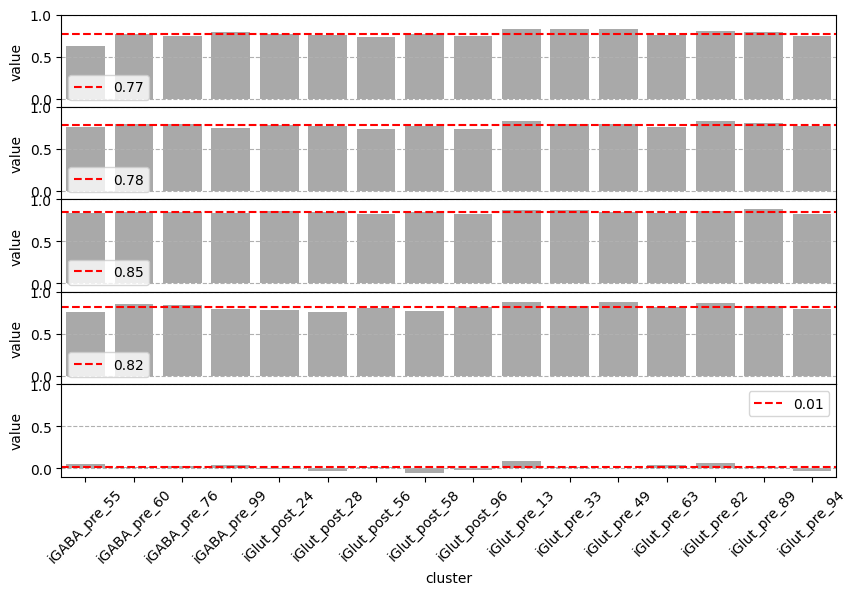

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming NNLS_overview is your DataFrame
# Melt the DataFrame to long format for Seaborn
df_melted = NNLS_overview.reset_index(drop=False).melt(id_vars='cluster', value_vars=['marker','TF', 'IC', 'syn', 'ox'], 
                                               var_name='metric', value_name='value')

# Create the figure and subplots
n_metrics = len(df_melted['metric'].unique())  # Number of unique metrics
fig, axes = plt.subplots(n_metrics, 1, figsize=(10, 6), sharex=True)

# Create a bar plot for each metric
for i, metric in enumerate(df_melted['metric'].unique()):
    # Subset the data for the current metric
    metric_data = df_melted[df_melted['metric'] == metric]
    
    # Create the bar plot
    sns.barplot(x='cluster', y='value', data=metric_data, ax=axes[i], color='darkgrey')
    
    # Calculate the mean and draw a horizontal line
    mean_value = metric_data['value'].mean()
    mean_value_str = "%.2f" % mean_value
    axes[i].axhline(mean_value, color='red', linestyle='--', label=mean_value_str)
    
    # Set title and limits
    #axes[i].set_title(metric)
    axes[i].set_ylim(-0.1, 1)  # Adjust based on expected value range
    axes[i].grid(axis='y', linestyle='--')
    
    # Add a legend to each subplot
    axes[i].legend()

# Adjust layout and show plot
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0)  # Adjust this value as needed
#plt.tight_layout()
plt.savefig("NNLS/correlation_gene_types_bars.pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()


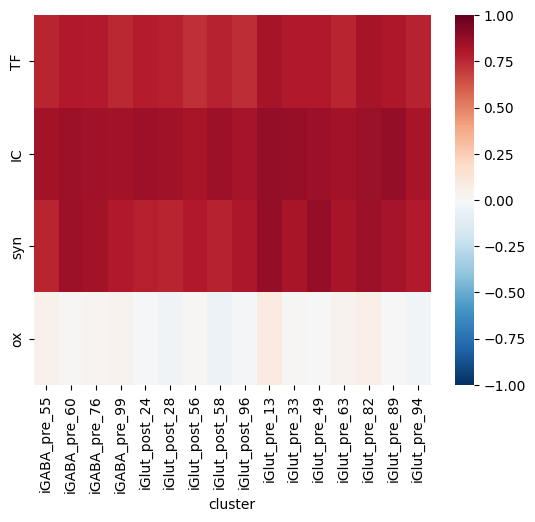

In [26]:
sns.heatmap(NNLS_overview[['TF','IC','syn','ox']].T,cmap='RdBu_r',vmin=-1,vmax=1)
plt.savefig("NNLS/correlation_gene_types.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [27]:
NT_meta_cluster = pd.read_csv("/cluster/home/jjanssens/jjans/analysis/primary_neurons_atlas_final/Table_SX_cluster_information_LT.tsv",sep="\t",index_col=0)

In [28]:
NT_meta_cluster = NT_meta_cluster.loc[matched_clusters_scores.index]

In [34]:
NT_meta_cluster.columns

Index(['Name', 'Division', 'Region', 'Subtype', 'Neuron_type', 'top_markers',
       'det_tfs', 'det_tfs_top2', 'uniq_tf_marker', 'det_NTs', 'det_NPs',
       'best_condition', 'best_condition_purity', 'DO1', 'DO1_genes', 'DO2',
       'DO2_genes', 'sample', 'cluster', 'source_cluster', 'LT_score'],
      dtype='object')

In [29]:
for region in ['Forebrain','Midbrain','Hindbrain','Spinal cord','DRG','TG','SYM','ENS']:
    NT_meta_cluster_region = NT_meta_cluster.loc[NT_meta_cluster['Region']==region]



In [30]:
matched_clusters_scores = pd.read_csv("NNLS/NNLS_results_marker_genes.tsv",sep="\t",index_col=0)

In [35]:
matched_clusters_scores['Region'] = NT_meta_cluster.loc[matched_clusters_scores.index,'Region']
matched_clusters_scores['Neuron_type'] = NT_meta_cluster.loc[matched_clusters_scores.index,'Neuron_type']
matched_clusters_scores['Division'] = NT_meta_cluster.loc[matched_clusters_scores.index,'Division']
matched_clusters_scores['best_condition'] = NT_meta_cluster.loc[matched_clusters_scores.index,'best_condition']

In [36]:
matched_clusters_scores

,primary_cluster,regr_weight,sample,Region,Neuron_type,Division,best_condition
iGABA_post_0,Braun_2023_598.0,0.018739,iGABA_post,Forebrain,GABA,CNS,iGABA_post_FGF8_2_BMP4_3_mTeSR
iGABA_post_1,Braun_2023_599.0,0.006825,iGABA_post,Hindbrain,GABA,CNS,iGABA_post_RA_4_BMP4_3_mTeSR
iGABA_post_2,Braun_2023_384.0,0.000000,iGABA_post,Forebrain,GABA,CNS,iGABA_post_FGF8_2_SHH_1_mTeSR
iGABA_post_3,Braun_2023_437.0,0.019373,iGABA_post,Forebrain,GABA,CNS,iGABA_post_CHIR_2_BMP4_1_mTeSR
iGABA_post_4,Braun_2023_439.0,0.064103,iGABA_post,Hindbrain,GABA,CNS,iGABA_post_RA_4_SHH_4_mTeSR
...,...,...,...,...,...,...,...
iGlut_pre_103,Zeisel_2018_98,0.002485,iGlut_pre,Hindbrain,GLUT,CNS,iGlut_pre_FGF8_3_BMP4_3_N2B27_SB_CHIR
iGlut_pre_104,Braun_2023_384.0,0.000000,iGlut_pre,Hindbrain,GLUT,CNS,iGlut_pre_CHIR_2_FGF8_BMP4_3_N2B27_2Si
iGlut_pre_105,Braun_2023_437.0,0.149986,iGlut_pre,Midbrain,GABA,CNS,iGlut_pre_CHIR_2_CycA_NIM
iGlut_pre_106,Braun_2023_393.0,0.024172,iGlut_pre,Forebrain,GLUT,CNS,iGlut_pre_CHIR_2_FGF8_CycA_NIM


In [37]:
matched_clusters_scores.loc[[x for x in matched_clusters_scores.index if 'iGlut' in x],'TF'] = 'NGN2'
matched_clusters_scores.loc[[x for x in matched_clusters_scores.index if 'iGABA' in x],'TF'] = 'ASCL1'

matched_clusters_scores.loc[[x for x in matched_clusters_scores.index if 'pre' in x],'timing'] = 'pre'
matched_clusters_scores.loc[[x for x in matched_clusters_scores.index if 'post' in x],'timing'] = 'post'

In [38]:
NT_meta_cluster.columns

Index(['Name', 'Division', 'Region', 'Subtype', 'Neuron_type', 'top_markers',
       'det_tfs', 'det_tfs_top2', 'uniq_tf_marker', 'det_NTs', 'det_NPs',
       'best_condition', 'best_condition_purity', 'DO1', 'DO1_genes', 'DO2',
       'DO2_genes', 'sample', 'cluster', 'source_cluster', 'LT_score'],
      dtype='object')

In [39]:
region_c = 0
matched_clusters_scores['region_c'] = 0
for region in ['Forebrain','Midbrain','Hindbrain','Spinal cord','DRG','TG','SYM','ENS']:
    matched_clusters_scores.loc[matched_clusters_scores['Region']==region,'region_c'] = region_c
    region_c+=1

In [40]:
color_dict_annots = {}
color_dict_annots['Forebrain'] = '#FF9A01'
color_dict_annots['Midbrain'] = '#F4C310'
color_dict_annots['Hindbrain'] = '#D8443D'
color_dict_annots['Spinal cord'] = '#9B3441'
color_dict_annots['SYM'] = '#248A8A'
color_dict_annots['ENS'] = '#1E6C99'
color_dict_annots['TG'] = '#373D81'
color_dict_annots['DRG'] = '#93BF51'
color_dict_annots['NE'] = '#EB7B82'

color_dict_annots['Optic cup'] = '#653373'

color_dict_annots['CNS'] = '#A40001'
color_dict_annots['PNS'] = '#12337D'

color_dict_annots['N2B27_SB_CHIR'] = '#102A4D'
color_dict_annots['N2B27_2Si'] = '#8DC7DD'
color_dict_annots['NIM'] = '#4E835E'


color_dict_annots['mTeSR'] = '#CBCCCC'
color_dict_annots['Other'] = '#CBCCCC'

color_dict_annots['GLUT'] = '#FE9B01'
color_dict_annots['GABA'] = '#F3C40E'
color_dict_annots['CHO'] = '#32A02D'
color_dict_annots['GLY'] = '#D8443D'
color_dict_annots['RGL'] = '#6A3D9A'
color_dict_annots['NBL'] = '#C9BBA2'
color_dict_annots['IP'] = '#AAB5D5'
color_dict_annots['NCC'] = '#92C050'
color_dict_annots['EPL'] = '#000000'
color_dict_annots['EC'] = '#99610A'
color_dict_annots['MES'] = '#CCCCCC'
color_dict_annots['EPC'] = '#CCCCCC'

color_dict_annots['OB'] = '#216E9C'
color_dict_annots['NOR'] = '#383B81'
color_dict_annots['DOPA'] = '#99363B'

color_dict_annots['NGN2'] = 'royalblue'
color_dict_annots['ASCL1'] = 'crimson'
color_dict_annots['post'] = 'black'
color_dict_annots['pre'] = 'white'

In [41]:
def qualheatmap(df,color_dict,figsize=(10,10),ax_heatmap=None):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import seaborn as sns
    
    available_keys = []
    for col in df.columns:
        df_col_values = list(set(df[col]))
        available_keys = available_keys + df_col_values
    available_keys = list(set(available_keys))
    
    color_dict_annot = {}
    for key in available_keys:
        try:
            color_dict_annot[key] = color_dict[key]
        except:
            print(key+" has no matching color in color_dict")
    
    
    # Create a unique list of colors based on the color_dict
    unique_colors = np.unique(list(color_dict_annot.values()))
    unique_colors = [x for x in unique_colors if x!='#000000']

    # Create a custom colormap using ListedColormap
    cmap = ListedColormap(unique_colors)

    # Map categorical values to integer values
    value_mapping = {category: i for i, category in enumerate(unique_colors)}
    mapped_data = df.applymap(lambda x: value_mapping.get(color_dict_annot.get(x, 'white')))

    # Create the heatmap using seaborn
    if not ax_heatmap:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        print('adding on existing axis')

    heatmap = sns.heatmap(mapped_data,
                        cmap=cmap,
                        ax = ax_heatmap,
                        cbar=False) 
    # alternative: use imshow to plot heatmap
    #    heatmap = plt.imshow(mapped_data, cmap=cmap)

    # Set axis labels and title
    plt.xticks(np.arange(len(df.columns)), df.columns)
    plt.yticks(np.arange(len(df)), df.index)
    
    if not ax_heatmap:
        return fig
    

In [43]:
matched_clusters_scores

,primary_cluster,regr_weight,sample,Region,Neuron_type,Division,best_condition,TF,timing,region_c
iGlut_pre_110,Braun_2023_384.0,0.000000,iGlut_pre,Forebrain,GLUT,CNS,iGlut_pre_XAV_3_FGF8_SHH_2_N2B27_2Si,NGN2,pre,0
iGABA_post_72,Yang_2022_15.0,0.000000,iGABA_post,TG,GABA,PNS,iGABA_post_XAV_3_BMP4_3_mTeSR,ASCL1,post,5
iGABA_pre_95,Yang_2022_15.0,0.000000,iGABA_pre,TG,GABA,PNS,iGABA_pre_XAV_1_BMP4_1_N2B27_2Si,ASCL1,pre,5
iGlut_pre_10,Braun_2023_384.0,0.000000,iGlut_pre,Midbrain,GLUT,CNS,iGlut_pre_CHIR_2_ctrl_NIM,NGN2,pre,1
iGABA_post_67,Yang_2022_15.0,0.000000,iGABA_post,TG,GABA,PNS,iGABA_post_CHIR_2_BMP4_2_mTeSR,ASCL1,post,5
...,...,...,...,...,...,...,...,...,...,...
iGlut_post_32,Yang_2022_13.0,0.158919,iGlut_post,TG,GLUT,PNS,iGlut_post_RA_1_CHIR_BMP4_3_mTeSR,NGN2,post,5
iGlut_pre_49,Braun_2023_458.0,0.187715,iGlut_pre,Hindbrain,GLY,CNS,iGlut_pre_RA_4_SHH_2_N2B27_SB_CHIR,NGN2,pre,2
iGlut_pre_63,Li_2023_4.0,0.193120,iGlut_pre,Spinal cord,GLUT,CNS,iGlut_pre_ctrl_BMP4_3_N2B27_SB_CHIR,NGN2,pre,3
iGlut_pre_82,Braun_2023_474.0,0.194932,iGlut_pre,Forebrain,GLUT,CNS,iGlut_pre_XAV_3_CycA_N2B27_2Si,NGN2,pre,0


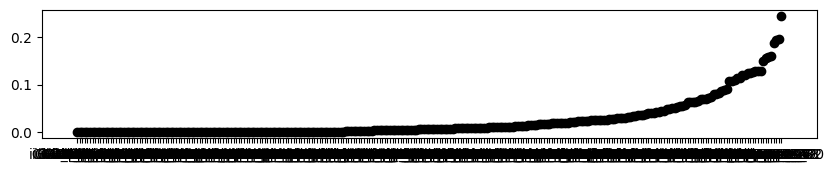

In [44]:
matched_clusters_scores = matched_clusters_scores.sort_values(by=['regr_weight'],)
#matched_clusters_scores = matched_clusters_scores.reset_index()
x,y = matched_clusters_scores.index,matched_clusters_scores['regr_weight']
plt.figure(figsize=(10,10/6))
plt.plot(x,y,'o',c='k')
plt.savefig("NNLS_regr_weight_sorted_scatter_plot.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("NNLS_regr_weight_sorted_scatter_plot.pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [121]:
cond_summary_plot_nctrl = matched_clusters_scores[['TF','timing','Division','Region','Neuron_type']]

In [122]:
mpl.rcParams['pdf.fonttype'] = 42


/scratch/tmp.9601056.jjanssens/ipykernel_3733196/851740362.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mapped_data = df.applymap(lambda x: value_mapping.get(color_dict_annot.get(x, 'white')))


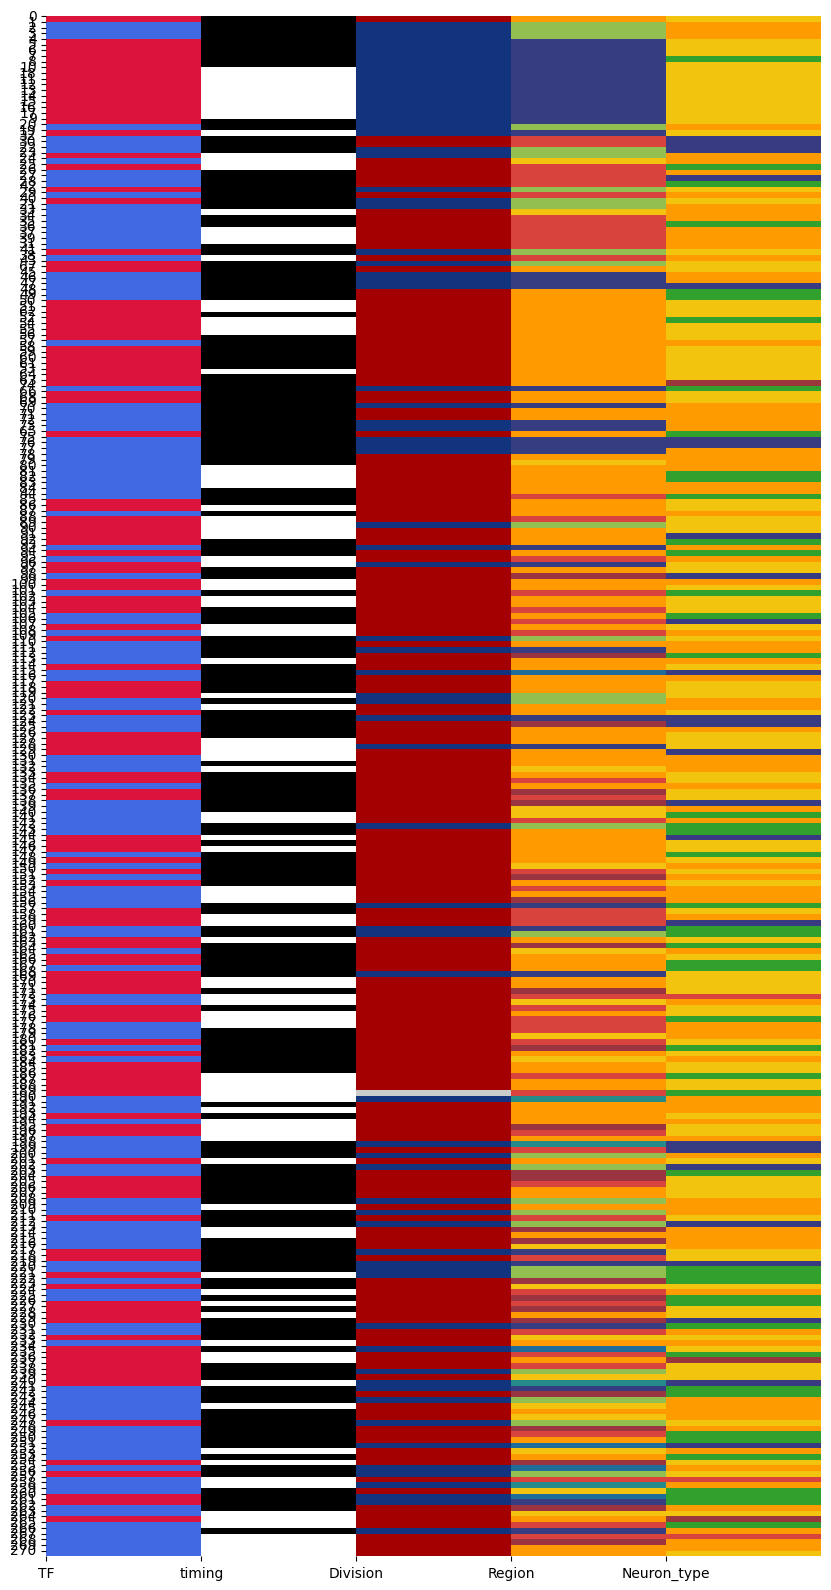

In [123]:
qualheatmap(cond_summary_plot_nctrl,
            figsize=(10,20),
            color_dict=color_dict_annots)
#plt.savefig("figures/dendrogram/conditions_colorcoded_axes_onlyNeur.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("NNLS_regr_weight_sorted_scatter_plot_annot_heatmap.pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("NNLS_regr_weight_sorted_scatter_plot_annot_heatmap.png",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [111]:
cond_summary_plot_nctrl

,Division,Region,Neuron_type
0,CNS,Forebrain,GABA
1,CNS,Forebrain,GABA
2,CNS,Forebrain,GABA
3,CNS,Forebrain,CHO
4,CNS,Forebrain,GABA
...,...,...,...
266,PNS,ENS,NOR
267,PNS,ENS,GABA
268,PNS,ENS,NOR
269,PNS,ENS,GLUT


In [68]:
matched_clusters_scores

,primary_cluster,regr_weight,sample
iGABA_post_0,Braun_2023_598.0,0.018739,iGABA_post
iGABA_post_1,Braun_2023_599.0,0.006825,iGABA_post
iGABA_post_2,Braun_2023_384.0,0.000000,iGABA_post
iGABA_post_3,Braun_2023_437.0,0.019373,iGABA_post
iGABA_post_4,Braun_2023_439.0,0.064103,iGABA_post
...,...,...,...
iGlut_pre_103,Zeisel_2018_98,0.002485,iGlut_pre
iGlut_pre_104,Braun_2023_384.0,0.000000,iGlut_pre
iGlut_pre_105,Braun_2023_437.0,0.149986,iGlut_pre
iGlut_pre_106,Braun_2023_393.0,0.024172,iGlut_pre


In [46]:
matched_clusters_scores.sort_values(by='regr_weight',ascending=False).head(n=20)

,primary_cluster,regr_weight,sample,Region,Neuron_type,Division,best_condition,TF,timing,region_c
iGlut_pre_70,Braun_2023_504.0,0.244520,iGlut_pre,Forebrain,GABA,CNS,iGlut_pre_XAV_3_SHH_2_NIM,NGN2,pre,0
iGlut_pre_82,Braun_2023_474.0,0.194932,iGlut_pre,Forebrain,GLUT,CNS,iGlut_pre_XAV_3_CycA_N2B27_2Si,NGN2,pre,0
iGlut_pre_63,Li_2023_4.0,0.193120,iGlut_pre,Spinal cord,GLUT,CNS,iGlut_pre_ctrl_BMP4_3_N2B27_SB_CHIR,NGN2,pre,3
iGlut_pre_49,Braun_2023_458.0,0.187715,iGlut_pre,Hindbrain,GLY,CNS,iGlut_pre_RA_4_SHH_2_N2B27_SB_CHIR,NGN2,pre,2
iGlut_post_32,Yang_2022_13.0,0.158919,iGlut_post,TG,GLUT,PNS,iGlut_post_RA_1_CHIR_BMP4_3_mTeSR,NGN2,post,5
iGlut_pre_94,Braun_2023_427.0,0.156889,iGlut_pre,Hindbrain,CHO,CNS,iGlut_pre_ctrl_SHH_2_N2B27_SB_CHIR,NGN2,pre,2
iGABA_pre_73,Braun_2023_328.0,0.154971,iGABA_pre,Forebrain,DOPA,CNS,iGABA_pre_XAV_1_SHH_2_N2B27_2Si,ASCL1,pre,0
iGlut_pre_105,Braun_2023_437.0,0.149986,iGlut_pre,Midbrain,GABA,CNS,iGlut_pre_CHIR_2_CycA_NIM,NGN2,pre,1
iGlut_post_56,Li_2023_4.0,0.129406,iGlut_post,Spinal cord,GLUT,CNS,iGlut_post_RA_1_CHIR_ctrl_mTeSR,NGN2,post,3
iGABA_post_44,Yang_2022_13.0,0.128683,iGABA_post,TG,CHO,PNS,iGABA_post_CHIR_4_BMP4_3_mTeSR,ASCL1,post,5


In [53]:
matched_clusters_scores

,primary_cluster,regr_weight,sample
iGABA_post_0,Braun_2023_598.0,0.018739,iGABA_post
iGABA_post_1,Braun_2023_599.0,0.006825,iGABA_post
iGABA_post_2,Braun_2023_384.0,0.000000,iGABA_post
iGABA_post_3,Braun_2023_437.0,0.019373,iGABA_post
iGABA_post_4,Braun_2023_439.0,0.064103,iGABA_post
...,...,...,...
iGlut_pre_103,Zeisel_2018_98,0.002485,iGlut_pre
iGlut_pre_104,Braun_2023_384.0,0.000000,iGlut_pre
iGlut_pre_105,Braun_2023_437.0,0.149986,iGlut_pre
iGlut_pre_106,Braun_2023_393.0,0.024172,iGlut_pre
